# 2024 COMP90042 Project
*Make sure you change the file name with your group id.*

# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

# 1.DataSet Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
!pip install nltk
!pip install scikit-learn
!pip install torchtext

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [13]:
import os
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/NLP Project'
os.chdir(folder_path)

print("Current Working Directory: ", os.getcwd())

Mounted at /content/drive
Current Working Directory:  /content/drive/My Drive/NLP Project


In [2]:
import random
import torch.optim as optim
import os
from tqdm import tqdm
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset

from torch.utils.data import DataLoader

In [14]:
import json
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_claims = json.load(open("train-claims.json", "r"))
dev_claims = json.load(open("dev-claims.json", "r"))
test_claims = json.load(open("test-claims-unlabelled.json", "r"))
evidences = json.load(open("evidence.json", "r"))

In [15]:
print(device)

cuda


In [16]:
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import re
nltk.download('stopwords')
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()

def lemmatize(word):
    lemma = lemmatizer.lemmatize(word,'v')
    if lemma == word:
        lemma = lemmatizer.lemmatize(word,'n')
    return lemma

tt = TweetTokenizer()
stopwords = set(stopwords.words('english')) #note: stopwords are all in lowercase

def preprocess_data(data):
    data = data.lower()
    tokenized_words= tt.tokenize(data) #tokenized
    remove_nonEnglish_data = [token for token in tokenized_words if re.search('[a-z]',token)]
    remove_stopword = [token for token in remove_nonEnglish_data if token not in stopwords] #remove stopword
    lemmatized = [lemmatize(token) for token in remove_stopword]

    sentence = " ".join(lemmatized)
    return sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
nltk.download('wordnet')
def obtain_claim (data):
    claims_id = []
    claims_text = []
    claims_label = []
    claims_evidence = []
    for key, value in data.items():
        claims_id.append(key)
        claims_text.append(preprocess_data(value["claim_text"]))
        claims_label.append(value["claim_label"])
        claims_evidence.append([evidence for evidence in value["evidences"]])
    return claims_id, claims_text, claims_label, claims_evidence

evidence_text = []
evidence_id = []
for key, value in evidences.items():
    processed = preprocess_data(value)
    evidence_text.append(processed)
    evidence_id.append(key)

dev_claims_id, dev_claims_text, dev_claims_label, dev_claims_evidence = obtain_claim(dev_claims)
train_claims_id, train_claims_text, train_claims_label, train_claims_evidence = obtain_claim(train_claims)

test_claims_id = []
test_claims_text = []
for key, value in test_claims.items():
    test_claims_id.append(key)
    test_claims_text.append(preprocess_data(value["claim_text"]))

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [18]:
def obtain_evidence_id (data):
    idlist = []
    for evidences in data:
        idlist.append([int(evidence.split('-')[1]) for evidence in evidences])
    return idlist

In [19]:
train_claims_evidence_id = obtain_evidence_id(train_claims_evidence)
dev_claims_evidence_id = obtain_evidence_id(dev_claims_evidence)

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(evidence_text)
evidence_matrix = vectorizer.transform(evidence_text)
train_text_matrix = vectorizer.transform(train_claims_text)
dev_text_matrix = vectorizer.transform(dev_claims_text)
test_text_matrix = vectorizer.transform(test_claims_text)

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_dev = cosine_similarity(dev_text_matrix, evidence_matrix)
similarity_test = cosine_similarity(test_text_matrix, evidence_matrix)

In [22]:
import numpy as np

def obtain_relevent_evidence_id (similarity):
    res = []
    for i in range(len(similarity)):
        #select the top 1000 related evidence
        sorted_indices = np.argsort(similarity[i])[::-1].tolist()[:100]
        res.append(sorted_indices)
    return res

In [23]:
def compute_similarity_in_chunks(train_text_matrix, evidence_matrix, chunk_size=100):
    n_samples_train = train_text_matrix.shape[0]
    n_samples_evidence = evidence_matrix.shape[0]

    similarity_matrix = np.zeros((n_samples_train, n_samples_evidence))

    for start_idx in range(0, n_samples_train, chunk_size):
        end_idx = min(start_idx + chunk_size, n_samples_train)
        train_batch = train_text_matrix[start_idx:end_idx, :]
        similarity_batch = cosine_similarity(train_batch, evidence_matrix)
        similarity_matrix[start_idx:end_idx, :] = similarity_batch

    return similarity_matrix

In [24]:
train_claims_relevent_evidence_id = []
for i in range(6):
  similarity_train = compute_similarity_in_chunks(train_text_matrix[i * 200 : (i + 1) * 200], evidence_matrix)
  train_claims_relevent_evidence_id += obtain_relevent_evidence_id (similarity_train)
similarity_train = compute_similarity_in_chunks(train_text_matrix[1200:], evidence_matrix)
train_claims_relevent_evidence_id += obtain_relevent_evidence_id (similarity_train)
del similarity_train

In [25]:
dev_claims_relevent_evidence_id = obtain_relevent_evidence_id (similarity_dev)
test_claims_relevent_evidence_id = obtain_relevent_evidence_id (similarity_test)

In [26]:
# obtain claim without tokenized and other preprosessing
def obtain_original_claim (data):
    claims_text = []
    for key, value in data.items():
        claims_text.append(value["claim_text"])
    return claims_text
original_train_claims = obtain_original_claim(train_claims)
original_dev_claims = obtain_original_claim(dev_claims)
original_test_claims = obtain_original_claim(test_claims)
original_evidence = []
for key,value in evidences.items():
    original_evidence.append(value)

In [27]:
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

def yield_tokens(texts):
    for text in texts:
        yield tokenizer(text)

# create vocab dict, only word which appeared >= 5 will counted otherwise treat as unknown
vocab = build_vocab_from_iterator(yield_tokens(evidence_text), specials=('<unk>', '<pad>', '<cls>'), min_freq = 10)

# create vocab_cls using unprocessed evidence texts
vocab_cls = build_vocab_from_iterator(yield_tokens(original_evidence), specials=('<unk>', '<pad>', '<cls>', '<sep>'), min_freq = 10)

vocab.set_default_index(vocab["<unk>"])
vocab_cls.set_default_index(vocab["<unk>"])
padding_index = vocab["<pad>"]
cls_index = vocab["<cls>"]
sep_index = vocab["<sep>"]

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [28]:
# vocab dict size
print(len(vocab))
print(len(vocab_cls))

53039
66446


In [29]:
def convert_word_to_idx (data, vocab_dict):
    res = []
    for sentence in data:
        indices = [vocab_dict[token] for token in tokenizer(sentence)]
        res.append(indices)
    return res

In [30]:
# convert token into idx, using processed data in retrieval later
train_claims_text_idx = convert_word_to_idx(train_claims_text, vocab)
dev_claims_text_idx = convert_word_to_idx(dev_claims_text, vocab)
test_claims_text_idx = convert_word_to_idx(test_claims_text, vocab)
evidence_text_idx = convert_word_to_idx(evidence_text, vocab)


In [31]:
# convert token into idx, using unprocessed data in classification later
train_claims_origianl_text_idx = convert_word_to_idx(original_train_claims, vocab_cls)
dev_claims_origianl_text_idx = convert_word_to_idx(original_dev_claims, vocab_cls)
test_claims_origianl_text_idx = convert_word_to_idx(original_test_claims, vocab_cls)
evidence_origianl_text_idx = convert_word_to_idx(original_evidence, vocab_cls)

In [32]:
def cal_average_len(data):
    total_length = sum(len(sentence) for sentence in data)
    return total_length / len(data)

print("mean length of train claims:", cal_average_len(train_claims_text_idx))
print("mean length of dev claims:", cal_average_len(dev_claims_text_idx))
print("mean length of test claims:", cal_average_len(test_claims_text_idx))
print("mean length of evidence:", cal_average_len(evidence_text_idx))
print()
print("mean length of original train claims:", cal_average_len(train_claims_origianl_text_idx))
print("mean length of original dev claims:", cal_average_len(dev_claims_origianl_text_idx))
print("mean length of original test claims:", cal_average_len(test_claims_origianl_text_idx))
print("mean length of original evidence:", cal_average_len(evidence_origianl_text_idx))

mean length of train claims: 11.862377850162867
mean length of dev claims: 12.474025974025974
mean length of test claims: 11.660130718954248
mean length of evidence: 11.273384032620053

mean length of original train claims: 22.43241042345277
mean length of original dev claims: 23.31168831168831
mean length of original test claims: 22.398692810457515
mean length of original evidence: 22.739117342680135


In [33]:
#construct input for retrieval
padded_claims_length = 25
padded_evidence_length = 25
def construct_input(data, padded_sentence_length):
    res = []
    for sentence in data:
        if len(sentence) < padded_sentence_length:
            res.append([vocab["<cls>"]] + sentence + [vocab["<pad>"]] * (padded_sentence_length - len(sentence)))
        else:
            res.append([vocab["<cls>"]] + sentence[:padded_sentence_length])
    return res

train_input = construct_input(train_claims_text_idx, padded_claims_length)
dev_input = construct_input(dev_claims_text_idx, padded_claims_length)
test_input = construct_input(test_claims_text_idx, padded_claims_length)
evidence_input = construct_input(evidence_text_idx, padded_evidence_length)

In [34]:
#construct input for classification
padded_claims_length_cls = 50
padded_evidence_length_cls = 50

train_input_cls = construct_input(train_claims_origianl_text_idx, padded_claims_length_cls)
dev_input_cls = construct_input(dev_claims_origianl_text_idx, padded_claims_length_cls)
test_input_cls = construct_input(test_claims_origianl_text_idx, padded_claims_length_cls)
evidence_input_cls = construct_input(evidence_origianl_text_idx, padded_evidence_length_cls)

In [35]:
import gc
del evidence_text, dev_claims_text, train_claims_text, test_claims_text, original_train_claims, original_dev_claims, original_test_claims, original_evidence, train_claims_text_idx, dev_claims_text_idx, test_claims_text_idx, evidence_text_idx
gc.collect()

0

In [36]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch

# dataset for evidence retrieval
class CustomDataset(Dataset):
    def __init__(self, _input, correct_evidence_id, relevent_evidences_id, incorrect_evidenct_num):
        self._input = _input
        self.correct_evidence_id = correct_evidence_id
        self.relevent_evidences_id = relevent_evidences_id
        self.incorrect_evidenct_num = incorrect_evidenct_num
        self._len = len(self._input)

    def __len__(self):
        return self._len

    def __getitem__(self, idx):
        return [self._input[idx], self.relevent_evidences_id[idx][100 - self.incorrect_evidenct_num:], self.correct_evidence_id[idx]]

def collate_batch(batch):
    claims = []
    evidences_id = []
    correct_evidences_id = []

    for claim, relevent_evidence, correct_evidence in batch:
        claims.append(claim)
        correct_evidences_id.append(correct_evidence)
        evidences_id.extend(relevent_evidence + correct_evidence)

    #remove duplicate
    evidences_id = list(set(evidences_id))


    evidences_to_inner_id = {j: idx for idx, j in enumerate(evidences_id)}
    correct_evidences_inner_id = [[evidences_to_inner_id[j] for j in idx] for idx in correct_evidences_id]

    evidences = [evidence_input[idx] for idx in evidences_id]

    batch_encoded = {}
    batch_encoded["claims"] = torch.LongTensor(claims)
    batch_encoded["evidences"] = torch.LongTensor(evidences)
    batch_encoded["correct_evidences_inner_id"] = correct_evidences_inner_id

    return batch_encoded

train_dataset = CustomDataset(train_input, train_claims_evidence_id, train_claims_relevent_evidence_id, 10)

dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=5, collate_fn = collate_batch)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [37]:
def mapping_index(indices):
    label_mapping = {
        0: 'SUPPORTS',
        1: 'REFUTES',
        2: 'NOT_ENOUGH_INFO',
        3: 'DISPUTED'
    }
    return [label_mapping[int(index)] for index in indices]


def mapping_string(string):
    if string == 'SUPPORTS':
        return 0
    if string == 'REFUTES':
        return 1
    if string == 'NOT_ENOUGH_INFO':
        return 2
    if string == 'DISPUTED':
        return 3

In [38]:
from torch.utils.data import Dataset
import random

# dataset for classification
class TrainDataset(Dataset):
    def __init__(self, claims_text, positive_evidences_id, cls_label):
        self.claims_text = claims_text
        self.positive_evidences_id = positive_evidences_id
        self.cls_label = cls_label
        self.text_length = len(claims_text[0])

    def __len__(self):
        return len(self.claims_text)

    def __getitem__(self, idx):
        return [self.claims_text[idx][:self.text_length], self.positive_evidences_id[idx], self.cls_label[idx]]

# For one claim, combine the claim texts and 5 evidence texts as a list, repeat for all claims in batch and return a [[]].
def collate_batch_CLS(batch):
    queries = []
    labels = []

    for claim_texts, positive_evidences_id, label in batch:
        # add cls to the front of texts denote start
        temp_text = [vocab_cls["<cls>"]]
        temp_text.extend(claim_texts)

        if len(positive_evidences_id) > 5:
            for i in range(5):
                temp_text.extend(evidence_input_cls[positive_evidences_id[i]])
        else:
            for i in positive_evidences_id:
                temp_text.extend(evidence_input_cls[i])
            # add padding to make up 5 * evidence length
            padding_needed = (5 - len(positive_evidences_id)) * padded_evidence_length_cls
            temp_text.extend([vocab_cls["<pad>"]] * padding_needed)

        # add sep to the end of texts denote finish
        temp_text.extend([vocab_cls["<sep>"]])

        queries.append(temp_text)
        labels.append(mapping_string(label))


    max_length = max(len(q) for q in queries)
    queries_padded = [q + [vocab_cls["<pad>"]] * (max_length - len(q)) for q in queries]

    batch_encoding = {}
    batch_encoding["queries"] = torch.LongTensor(queries_padded)
    batch_encoding["labels"] = torch.LongTensor(labels)

    return batch_encoding

# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

2.1. Retrieval Model

In [39]:
# tut8
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) #0::2 means starting with index 0, step = 2
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [40]:
class TransformerModel(nn.Module):

    def __init__(self, vocabsize, modeldim, nhead, nhid, nlayers):
        super(TransformerModel, self).__init__()
        self.pos_encoder = PositionalEncoding(modeldim)
        encoder_layers = TransformerEncoderLayer(modeldim, nhead, nhid, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers, norm=nn.LayerNorm(nhid))
        self.encoder = nn.Embedding(vocabsize, modeldim)
        self.modeldim = modeldim

    def forward(self, claims):
        _mask = claims == 1
        claims_position = self.encoder(claims)
        claims_position = self.pos_encoder(claims_position)
        encoded = self.transformer_encoder(claims_position, src_key_padding_mask = _mask)
        return encoded

In [41]:
trans_encoder = TransformerModel(vocabsize=len(vocab), modeldim=1024, nhead=8, nhid=1024, nlayers=6)
torch.cuda.empty_cache()
trans_encoder.to(device)

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (encoder): Embedding(53039, 1024)
)

2.2. Classification Model

In [46]:
class CLS(nn.Module):
    def __init__(self, vocabsize, modeldim, nhead, nhid, nlayers, output_size):
        super(CLS, self).__init__()
        self.pos_encoder = PositionalEncoding(modeldim)
        encoder_layers = TransformerEncoderLayer(modeldim, nhead, nhid, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers, norm=nn.LayerNorm(nhid))
        self.encoder = nn.Embedding(vocabsize, modeldim)
        self.modeldim = modeldim
        self.hidden_layer = nn.Linear(nhid, nhid // 2)
        self.cls = nn.Linear(nhid // 2, output_size)
        self.dropout = nn.Dropout(0.1)

    def forward(self, claims):
        _mask = claims == 1
        claims_position = self.encoder(claims)
        claims_position = self.pos_encoder(claims_position)
        encoded = self.transformer_encoder(claims_position, src_key_padding_mask = _mask)
        claims_cls = encoded[:, 0, :]
        claims_hidden = F.tanh(self.hidden_layer(claims_cls))
        self.dropout(claims_hidden)
        result = self.cls(claims_hidden)
        return result

In [47]:
class EarlyStopping:
    def __init__(self, patience=3, min_change=0.01):
        self.patience = patience
        self.min_change = min_change
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_change:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [42]:
# Evidence retrival

from torch.utils.data import TensorDataset
retrieval_num = 5
candidate_num = 10


def validate(claims_input, evidence_idx, to_local_index, relevent_evidence_id, correct_evidence_id, model):
    # get evidence embeddings
    model.eval()
    batch_size = 1000
    evidence_len = len(evidence_idx[0])
    text_len = len(claims_input[0])

    # obtain the query embedding
    # query = torch.LongTensor(claims_input).view(-1, text_len).cuda()
    query = torch.LongTensor(claims_input).view(-1, text_len).to(device)
    query_embedding = model(query)
    query_embedding = query_embedding[:, 0, :].detach()
    query_embedding = F.normalize(query_embedding, p=2, dim=1).cpu()

    evidence_embeddings = []

    # batch by batch to get all evidence embedding, if do in once will overflow

    dataset = TensorDataset(torch.LongTensor(evidence_idx))
    data_loader = DataLoader(dataset, batch_size=batch_size, pin_memory=True, num_workers=0)
    evidence_embeddings = []
    for batch in data_loader:
        # cur_evidence = batch[0].cuda()
        cur_evidence = batch[0].to(device)
        cur_embedding = model(cur_evidence)
        # need to put in cpu to prevent tensors in different devices, all in gpu might overflow
        cur_embedding = cur_embedding[:, 0, :].detach().cpu()
        cur_embedding = F.normalize(cur_embedding, p=2, dim=1)
        evidence_embeddings.append(cur_embedding)

    del dataset, data_loader

    # concat the list of tensors into tensors
    evidence_embeddings = torch.cat(evidence_embeddings, dim=0)

    scores = torch.mm(query_embedding, evidence_embeddings.t())
    f = []

    # from eval.py
    for i in range(scores.size(0)):
        local_indices = [to_local_index[idx] for idx in relevent_evidence_id[i][:candidate_num]]
        candidates_score = torch.index_select(scores[i], 0, torch.LongTensor(local_indices))
        topk = torch.argsort(candidates_score, descending = True).tolist()
        selected = topk[:retrieval_num]

        evidence_correct = 0
        pred_evidences = [relevent_evidence_id[i][j] for j in selected]
        for evidence_id in correct_evidence_id[i]:
            if evidence_id in pred_evidences:
                evidence_correct += 1
        if evidence_correct > 0:
            evidence_recall = float(evidence_correct) / len(correct_evidence_id[i])
            evidence_precision = float(evidence_correct) / len(pred_evidences)
            evidence_fscore = (2 * evidence_precision * evidence_recall) / (evidence_precision + evidence_recall)
        else:
            evidence_fscore = 0
        f.append(evidence_fscore)

    fscore = np.mean(f)
    print("Evidence Retrieval F-score: %.3f" % fscore)
    model.train()
    return fscore

In [43]:
def filter_useful_evidences(data, relative_evidence_id):
  to_local_index = {}
  count = 0
  res = []
  for i in range(len(relative_evidence_id)):
    # select the top candidate_num
    for j in range(candidate_num):
      if relative_evidence_id[i][j] not in to_local_index:
        res.append(data[relative_evidence_id[i][j]])
        to_local_index[relative_evidence_id[i][j]] = count
        count += 1
  return res, to_local_index

In [44]:
#  Evidence retrival training
import random
import torch.optim as optim
import os
from tqdm import tqdm
import numpy as np
from statistics import mean

lr = 0.0005
optimizer = torch.optim.SGD(trans_encoder.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

all_loss = []
all_step = []
step_accu = 0
steps = 0

torch.manual_seed(7)
torch.cuda.manual_seed_all(7)
random.seed(7)

# parameter to contraol the temp status printout and model performance evaluation
count = 0
total_steps = 0
step_length = 5
report_freq = 5
eval_interval = 20

current_dir = os.getcwd()
save_path = os.path.join(current_dir, "best_model.bin")

trans_encoder.train()
avg_loss = 0
optimizer.zero_grad()
maximum_f_score = 0

for epoch in range(2):
    step_accu += steps
    steps = 0

    for (i, batch) in enumerate(tqdm(dataloader)):

        count += 1
    # forward pass
        # claim_embeddings = trans_encoder(batch["claims"].cuda())
        # evidence_embeddings = trans_encoder(batch["evidences"].cuda())
        claim_embeddings = trans_encoder(batch["claims"].to(device))
        evidence_embeddings = trans_encoder(batch["evidences"].to(device))

        # reduce dimension from batch size * sentence len * embedding dimesion to batch size *  embedding by considering the first word
        # since first word is the <cls> which have no other meaning, after training can accumuminate information in it, reduce the amount of calcualtion, also reduce the accuracy
        claim_embeddings = claim_embeddings[:, 0, :]
        evidence_embeddings = evidence_embeddings[:, 0, :]

        # L2 normalization for every row
        claim_embeddings = F.normalize(claim_embeddings, p=2, dim=1)
        evidence_embeddings = F.normalize(evidence_embeddings, p=2, dim=1)

        # calculate similarity by dot product
        similarity = torch.mm(claim_embeddings, evidence_embeddings.t())

        scores = - F.log_softmax(similarity / 0.1, dim=1)
        scores_list = scores.tolist()
    # backward pass
        loss = []
        for idx, correct_id in enumerate(batch["correct_evidences_inner_id"]):
            # correct_id = torch.LongTensor(correct_id).cuda()
            correct_id = torch.LongTensor(correct_id).to(device)
            # calculate the average score for each correct evidence in each claim
            cur_loss = torch.mean(torch.index_select(scores[idx], 0, correct_id))
            loss.append(cur_loss)
        # stack the loss tensor then calculate mean of average loss, since they might have diffenent dimension
        loss = torch.stack(loss).mean()
        loss = loss / step_length
        loss.backward()
        avg_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()

        if count == step_length:
            count = 0
            steps += 1
            total_steps += 1

        if total_steps % report_freq == 0 and count == 0:
            print("epoch: %d, steps: %d, avg loss: %.6f" % (epoch, steps, avg_loss / report_freq))
            all_step.append(step_accu + steps)
            all_loss.append(avg_loss/ report_freq)
            avg_loss = 0
        del loss, similarity, claim_embeddings, evidence_embeddings

        # test current model with dev dataset
        if total_steps % eval_interval == 0 and count == 0:
            print("\nEvaluate:\n")
            select_evidences, to_local_index = filter_useful_evidences(evidence_input, dev_claims_relevent_evidence_id)
            f_score = validate(dev_input, select_evidences, to_local_index, dev_claims_relevent_evidence_id, dev_claims_evidence_id, trans_encoder)
            if f_score > maximum_f_score:
                maximum_f_score = f_score
                torch.save(trans_encoder.state_dict(), save_path)
                print("best f-score:", f_score)

  0%|          | 0/246 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 11%|█         | 26/246 [00:05<00:29,  7.36it/s]

epoch: 0, steps: 5, avg loss: 4.263636


 21%|██        | 51/246 [00:09<00:27,  7.15it/s]

epoch: 0, steps: 10, avg loss: 4.351270


 31%|███       | 76/246 [00:12<00:23,  7.28it/s]

epoch: 0, steps: 15, avg loss: 4.249545


 40%|████      | 99/246 [00:15<00:20,  7.18it/s]

epoch: 0, steps: 20, avg loss: 4.203184

Evaluate:

Evidence Retrieval F-score: 0.069


 41%|████      | 100/246 [00:44<20:55,  8.60s/it]

best f-score: 0.06900639043496189


 51%|█████     | 126/246 [00:47<00:16,  7.13it/s]

epoch: 0, steps: 25, avg loss: 4.178691


 61%|██████▏   | 151/246 [00:51<00:13,  7.29it/s]

epoch: 0, steps: 30, avg loss: 4.164424


 72%|███████▏  | 176/246 [00:54<00:10,  6.91it/s]

epoch: 0, steps: 35, avg loss: 4.184547


 81%|████████  | 199/246 [00:58<00:08,  5.57it/s]

epoch: 0, steps: 40, avg loss: 4.116689

Evaluate:



 82%|████████▏ | 201/246 [00:59<00:15,  2.83it/s]

Evidence Retrieval F-score: 0.068


 92%|█████████▏| 226/246 [01:03<00:03,  5.74it/s]

epoch: 0, steps: 45, avg loss: 4.162113


  2%|▏         | 5/246 [00:01<00:54,  4.45it/s]

epoch: 1, steps: 1, avg loss: 4.022460


 12%|█▏        | 30/246 [00:05<00:31,  6.90it/s]

epoch: 1, steps: 6, avg loss: 4.106402


 22%|██▏       | 53/246 [00:08<00:26,  7.19it/s]

epoch: 1, steps: 11, avg loss: 4.108038

Evaluate:



 22%|██▏       | 55/246 [00:09<00:58,  3.25it/s]

Evidence Retrieval F-score: 0.065


 33%|███▎      | 80/246 [00:13<00:23,  7.09it/s]

epoch: 1, steps: 16, avg loss: 4.042874


 43%|████▎     | 105/246 [00:16<00:20,  6.90it/s]

epoch: 1, steps: 21, avg loss: 4.132701


 53%|█████▎    | 130/246 [00:20<00:17,  6.71it/s]

epoch: 1, steps: 26, avg loss: 4.078761


 62%|██████▏   | 153/246 [00:23<00:13,  6.98it/s]

epoch: 1, steps: 31, avg loss: 4.076507

Evaluate:



 63%|██████▎   | 155/246 [00:24<00:28,  3.23it/s]

Evidence Retrieval F-score: 0.066


 73%|███████▎  | 180/246 [00:28<00:09,  7.14it/s]

epoch: 1, steps: 36, avg loss: 4.117926


 83%|████████▎ | 205/246 [00:32<00:05,  6.97it/s]

epoch: 1, steps: 41, avg loss: 4.090560


 93%|█████████▎| 230/246 [00:35<00:02,  6.70it/s]

epoch: 1, steps: 46, avg loss: 4.064545


100%|██████████| 246/246 [00:38<00:00,  6.39it/s]


Text(0, 0.5, 'average loss')

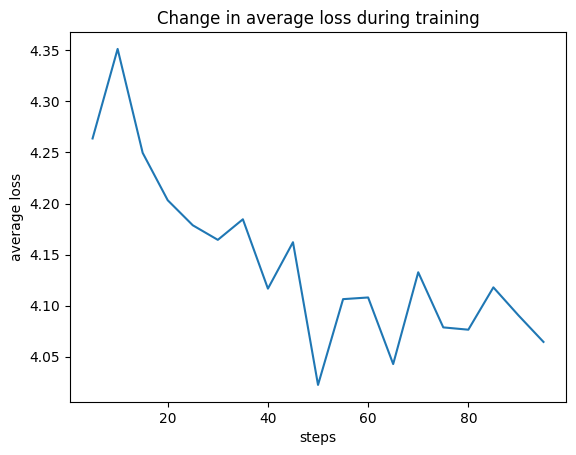

In [45]:
import matplotlib.pyplot as plt
plt.plot(all_step, all_loss)
plt.title('Change in average loss during training')
plt.xlabel('steps')
plt.ylabel('average loss')

In [48]:
# Classification
def train(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['queries'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['queries'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids)
            loss = criterion(outputs,labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=-1)  # Directly call argmax on outputs
            total_correct += (preds == labels).sum().item()
    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / len(data_loader.dataset)
    return avg_loss, accuracy

In [57]:
# Classification
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
def cross_validate_model(model, optimizer, criterion, dataset, num_splits=5, batch_size=32, num_epochs=4):
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)
    results = []
    best_model = None
    best_accuracy = 0.0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    stop = False

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        if stop:
            break

        print(f"Folding {fold+1}/{num_splits}")
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch_CLS)
        valid_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch_CLS)
        early_stopping = EarlyStopping(patience=3, min_change=0.001)
        best_fold_model = None
        best_fold_accuracy = 0.0

        for epoch in range(num_epochs):
            train_loss = train(model, train_loader, optimizer, criterion)
            eval_loss, eval_accuracy = evaluate(model, valid_loader, criterion)
            print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {eval_loss}, Accuracy: {eval_accuracy}')
            dev_loader = DataLoader(dev_dataset_CLS, batch_size=10, shuffle=True, collate_fn=collate_batch_CLS)
            dev_loss, dev_accuracy = evaluate(model, dev_loader, criterion)
            print(f"dev_accuray is {dev_accuracy}")

            if dev_accuracy > 0.60:
                print(f"Stopping early: dev_accuracy = {dev_accuracy} > 0.6")
                stop = True
                break

            if eval_accuracy > best_fold_accuracy:
                best_fold_accuracy = eval_accuracy

            early_stopping(eval_loss)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        results.append((eval_loss, eval_accuracy))
        print(f"Validation Loss: {eval_loss:.4f}, Accuracy: {eval_accuracy:.4f}")

        if best_fold_accuracy > best_accuracy:
            best_accuracy = best_fold_accuracy

    avg_loss = sum([x[0] for x in results]) / num_splits
    avg_accuracy = sum([x[1] for x in results]) / num_splits

    return avg_loss, avg_accuracy

In [50]:
train_dataset_CLS = TrainDataset(train_input_cls,train_claims_evidence_id,train_claims_label)
dev_dataset_CLS = TrainDataset(dev_input_cls, dev_claims_evidence_id, dev_claims_label)

In [56]:
cls_model = CLS(vocabsize=len(vocab_cls), modeldim=512, nhead=8, nhid=512, nlayers=6, output_size=4)
cls_model.to(device)
optimizer = torch.optim.Adam(cls_model.parameters(), lr=0.00005)
criterion = nn.CrossEntropyLoss()

In [58]:
avg_loss, avg_accuracy = cross_validate_model(cls_model, optimizer, criterion, train_dataset_CLS)
print(f'Average Validation Loss: {avg_loss:.4f}, Average Accuracy: {avg_accuracy:.4f}')

Folding 1/5


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 13.27it/s]


Epoch 1, Train Loss: 1.291153738575597, Validation Loss: 1.2599556893110275, Accuracy: 0.45934959349593496


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.80it/s]


dev_accuray is 0.44805194805194803


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 12.83it/s]


Epoch 2, Train Loss: 1.256526497102553, Validation Loss: 1.2522450238466263, Accuracy: 0.47560975609756095


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.90it/s]


dev_accuray is 0.44805194805194803


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 12.80it/s]


Epoch 3, Train Loss: 1.2520476195120043, Validation Loss: 1.2333583235740662, Accuracy: 0.45934959349593496


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 38.63it/s]


dev_accuray is 0.44155844155844154


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 12.78it/s]


Epoch 4, Train Loss: 1.2298034410322867, Validation Loss: 1.1807177513837814, Accuracy: 0.5203252032520326


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 38.72it/s]


dev_accuray is 0.538961038961039
Validation Loss: 1.1807, Accuracy: 0.5203
Folding 2/5


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 12.78it/s]


Epoch 1, Train Loss: 1.1469873170698843, Validation Loss: 1.1065945625305176, Accuracy: 0.5650406504065041


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.11it/s]


dev_accuray is 0.45454545454545453


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 12.88it/s]


Epoch 2, Train Loss: 1.080128498615757, Validation Loss: 1.018149845302105, Accuracy: 0.5609756097560976


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 38.06it/s]


dev_accuray is 0.5714285714285714


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 12.92it/s]


Epoch 3, Train Loss: 1.0521365461810943, Validation Loss: 1.102496363222599, Accuracy: 0.5284552845528455


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 38.82it/s]


dev_accuray is 0.5454545454545454


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 13.07it/s]


Epoch 4, Train Loss: 1.0595458688274506, Validation Loss: 1.1710958182811737, Accuracy: 0.45121951219512196


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.89it/s]


dev_accuray is 0.5064935064935064
Validation Loss: 1.1711, Accuracy: 0.4512
Folding 3/5


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 12.97it/s]


Epoch 1, Train Loss: 1.03174041932629, Validation Loss: 1.0470609590411186, Accuracy: 0.5609756097560976


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.31it/s]


dev_accuray is 0.5714285714285714


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 12.73it/s]


Epoch 2, Train Loss: 1.014559515060917, Validation Loss: 0.982265017926693, Accuracy: 0.5934959349593496


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 38.80it/s]


dev_accuray is 0.5454545454545454


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 13.17it/s]


Epoch 3, Train Loss: 0.9747637414163158, Validation Loss: 1.0404684096574783, Accuracy: 0.573170731707317


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.47it/s]


dev_accuray is 0.551948051948052


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 12.84it/s]


Epoch 4, Train Loss: 0.9887466642164415, Validation Loss: 0.9276233240962029, Accuracy: 0.6056910569105691


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.33it/s]

dev_accuray is 0.6103896103896104
Stopping early: dev_accuracy = 0.6103896103896104 > 0.6
Validation Loss: 0.9276, Accuracy: 0.6057
Average Validation Loss: 0.6559, Average Accuracy: 0.3154


In [60]:
dev_loader = DataLoader(dev_dataset_CLS, batch_size=10, shuffle=True, collate_fn=collate_batch_CLS)
dev_loss, dev_accuracy = evaluate(cls_model, dev_loader, criterion)
print(f'Development Loss: {dev_loss:.4f}, Accuracy: {dev_accuracy:.4f}')

Evaluating: 100%|██████████| 16/16 [00:00<00:00, 33.10it/s]

Development Loss: 0.9980, Accuracy: 0.6104


Retrieval Modelc Prediction

In [61]:
# load the best performed model in dev dataset
torch.cuda.empty_cache()
trans_encoder.load_state_dict(torch.load(save_path))
trans_encoder.to(device)
trans_encoder.eval()

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (encoder): Embedding(53039, 1024)
)

In [62]:
retrieval_num = 5
candidate_num = 6

def evidence_predicts(claims_input, relevent_evidence_id, evidences_id, model):
    # obtain evidence embeddings
    batch_size = 1000
    select_evidences, to_local_index = filter_useful_evidences(evidence_input, relevent_evidence_id)
    dataset = TensorDataset(torch.LongTensor(select_evidences))
    data_loader = DataLoader(dataset, batch_size=batch_size, pin_memory=True, num_workers=0)
    evidence_embeddings = []
    for batch in data_loader:
        # cur_evidence = batch[0].cuda()
        cur_evidence = batch[0].to(device)
        cur_embedding = trans_encoder(cur_evidence)
        # need to put in cpu to prevent tensors in different devices, all in gpu might overflow
        cur_embedding = cur_embedding[:, 0, :].detach().cpu()
        cur_embedding = F.normalize(cur_embedding, p=2, dim=1)
        evidence_embeddings.append(cur_embedding)

    del dataset, data_loader

    # concat the list of tensors into tensors
    evidence_embeddings = torch.cat(evidence_embeddings, dim=0).t()

    text_len = len(claims_input[0])
    model.eval()

    # query = torch.LongTensor(claims_input).view(-1, text_len).cuda()
    query = torch.LongTensor(claims_input).view(-1, text_len).to(device)
    query_embedding = model(query)
    query_embedding = query_embedding[:, 0, :].detach()
    query_embedding = F.normalize(query_embedding, p=2, dim=1).cpu()

    scores = torch.mm(query_embedding, evidence_embeddings)
    pred = []
    for i in range(scores.size(0)):
        local_indices = [to_local_index[idx] for idx in relevent_evidence_id[i][:candidate_num]]
        candidates_score = torch.index_select(scores[i], 0, torch.LongTensor(local_indices))
        topk = torch.argsort(candidates_score, descending = True).tolist()
        selected = topk[:retrieval_num]

        pred_evidences = [evidences_id[relevent_evidence_id[i][j]] for j in selected]
        pred.append(pred_evidences)

    return pred

In [63]:
pred_test_evidence = evidence_predicts(test_input, test_claims_relevent_evidence_id, evidence_id, trans_encoder)

In [64]:
i = 0
for key, value in test_claims.items():
    value["evidences"] = pred_test_evidence[i]
    i += 1
json.dump(test_claims, open("test_claims.json", "w"))

Classification Model Predictions

In [65]:
import json


dir_path = 'test_claims.json'


with open(dir_path, 'r') as file:
    data = json.load(file)

In [66]:

claims = []
evidences = []


for claim_id, claim_data in data.items():
    claim_text = claim_data['claim_text']
    evidence_ids = claim_data['evidences']


    claims.append(claim_text)
    evidences.append(evidence_ids)

evidences = obtain_evidence_id(evidences)

def collate_batch_cls(batch):
    queries = []


    for claim_texts, positive_evidences_id in batch:
        # Add cls to the front of texts to denote start
        temp_text = [vocab_cls["<cls>"]]  # Assuming <cls> token is 2
        temp_text.extend(claim_texts)

        if len(positive_evidences_id) > 5:
            for i in range(5):
                temp_text.extend(evidence_input_cls[positive_evidences_id[i]])
        else:
            for i in positive_evidences_id:
                temp_text.extend(evidence_input_cls[i])
            # Add padding to make up 5 * evidence length
            padding_needed = (5 - len(positive_evidences_id)) * padded_evidence_length_cls
            temp_text.extend([vocab_cls["<pad>"]] * padding_needed)


        temp_text.extend([vocab_cls["<sep>"]])  # Assuming <sep> token is 3

        queries.append(temp_text)


    # Pad sequences to the same length
    max_length = max(len(q) for q in queries)
    queries_padded = [q + [vocab_cls["<pad>"]] * (max_length - len(q)) for q in queries]

    batch_encoding = {}
    batch_encoding["queries"] = torch.LongTensor(queries_padded)

    return batch_encoding


class testDataset(Dataset):
    def __init__(self, claims_text, positive_evidences_id):
        self.claims_text = claims_text
        self.positive_evidences_id = positive_evidences_id
        self.text_length = len(claims_text[0])

    def __len__(self):
        return len(self.claims_text)

    def __getitem__(self, idx):
        return [self.claims_text[idx][:self.text_length], self.positive_evidences_id[idx]]

test_dataset_CLS = testDataset(test_input_cls,evidences)
test_loader = DataLoader(test_dataset_CLS, batch_size=5, shuffle=True, collate_fn=collate_batch_cls)


In [67]:
from collections import Counter
def label_predict(loader, model):
    model.to(device)
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Predicting"):
            queries = batch["queries"].to(device)
            outputs = model(queries)
            preds = torch.argmax(outputs, dim=1).tolist()
            predictions.extend(preds)

    return predictions


predictions = label_predict(test_loader, cls_model)
print(Counter(predictions))

Predicting: 100%|██████████| 31/31 [00:00<00:00, 61.49it/s]

Counter({0: 93, 2: 60})


In [68]:
i = 0
predictions = mapping_index(predictions)
for key, value in test_claims.items():
    value["claim_label"] = predictions[i]
    i+=1
json.dump(test_claims, open("test_claims.json", "w"))

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*